In [1]:
import pickle
from transformers import AutoTokenizer
import numpy as np
import shap
from src.plot_text import text, get_grouped_vals

# from src.utils import format_fts_for_plotting, text_ft_index_ends, token_segments
# from src.utils import legacy_get_dataset_info
from datasets import load_dataset

# import matplotlib.pyplot as plt
from src.run_shap import load_shap_vals
from tqdm import tqdm

import pandas as pd
from src.utils import (
    ConfigLoader,
    text_ft_index_ends,
    token_segments,
    format_fts_for_plotting,
    format_text_fts_too,
)

In [2]:
configs = [
    "vet_50c_all_text",
    "vet_59c_ensemble_25",
    "vet_59c_ensemble_50",
    "vet_59c_ensemble_75",
    "vet_59c_stack",
    "vet_10c_all_text",
    "vet_19c_ensemble_25",
    "vet_19c_ensemble_50",
    "vet_19c_ensemble_75",
    "vet_19c_stack",
]

In [3]:
df = pd.DataFrame(columns=["config", "phrase", "value"])

for config in configs:
    with open(
        f"/home/james/CodingProjects/ExplainPetBERT/{config}_all_tokens.pkl", "rb"
    ) as f:
        all_tokens = pickle.load(f)
    with open(
        f"/home/james/CodingProjects/ExplainPetBERT/{config}_all_values.pkl", "rb"
    ) as f:
        all_values = pickle.load(f)
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "config": [config for _ in range(len(all_tokens))],
                    "phrase": all_tokens,
                    "value": -all_values,  # negative because then it represents the vals for alive
                }
            ),
        ],
        ignore_index=True,
    )

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [4]:
args = ConfigLoader(
    "vet_50c_all_text",
    "../configs/shap_configs.yaml",
    "../configs/dataset_default.yaml",
)

tab_cols = args.categorical_cols + args.numerical_cols

Updating with:
{'config': 'vet_50c_all_text', 'my_text_model': 'james-burton/vet_50c', 'ds_name': 'james-burton/vet_month_1c_all_text', 'text_model_base': 'SAVSNET/PetBERT_pretrained', 'model_type': 'all_text', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating i

In [5]:
# check if each row in df contains tab_col + " ="
# if so, mark as tabular

df["tabular"] = [False for _ in range(len(df))]
for i, row in tqdm(df.iterrows()):
    for col in tab_cols:
        if col + " =" in row["phrase"]:
            df.loc[i, "tabular"] = True
            break

0it [00:00, ?it/s]

399876it [00:32, 12398.60it/s]


In [6]:
df["count"] = [1 for _ in range(len(df))]

In [7]:
df = df[df["tabular"] == False]

In [8]:
with open(
    f"/home/james/CodingProjects/ExplainPetBERT/{config}_tab_tokens.pkl", "rb"
) as f:
    tab_tokens = pickle.load(f)
    # reshape to be one dimensional
    # tab_tokens = [token for sublist in tab_tokens for token in sublist]
with open(
    f"/home/james/CodingProjects/ExplainPetBERT/{config}_tab_values.pkl", "rb"
) as f:
    tab_values = pickle.load(f)
    # tab_values = [val for sublist in tab_values for val in sublist]

In [9]:
tab_tokens.reshape(-1).shape

(25000,)

In [10]:
tab_tokens.shape

(1000, 25)

In [11]:
tab_values.shape

(1000, 25)

In [12]:
for config in configs:
    with open(
        f"/home/james/CodingProjects/ExplainPetBERT/{config}_tab_tokens.pkl", "rb"
    ) as f:
        tab_tokens = pickle.load(f)
    with open(
        f"/home/james/CodingProjects/ExplainPetBERT/{config}_tab_values.pkl", "rb"
    ) as f:
        tab_values = pickle.load(f)
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "config": [config for _ in range(len(tab_tokens.reshape(-1)))],
                    "phrase": tab_tokens.reshape(-1),
                    "value": tab_values.reshape(-1),
                    "tabular": [True for _ in range(len(tab_tokens.reshape(-1)))],
                    "count": [1 for _ in range(len(tab_tokens.reshape(-1)))],
                }
            ),
        ],
        ignore_index=True,
    )

In [13]:
df

,config,phrase,value,tabular,count
0,vet_50c_all_text,(Text ft) breed = missing (Text ft) region =...,0.003296,False,1
1,vet_50c_all_text,(Text ft) record = owner rep not quite,0.006663,False,1
2,vet_50c_all_text,hersel.,-0.011007,False,1
3,vet_50c_all_text,either really hungry or eating very little.,-0.042159,False,1
4,vet_50c_all_text,occ v+ chronic,0.006198,False,1
...,...,...,...,...,...
553725,vet_19c_stack,Perinatal = 0,-0.001015,True,1
553726,vet_19c_stack,Pregnancy_Childbirth_or_Puerperium = 0,-0.001015,True,1
553727,vet_19c_stack,Respiratory = 0,-0.005172,True,1
553728,vet_19c_stack,Injury_Poisoning_or_External_Causes = 1,0.012196,True,1


In [22]:
bert_cfgs = [
    # "vet_10c_all_text",
    # "vet_19c_ensemble_25",
    "vet_19c_ensemble_50",
    # "vet_19c_ensemble_75",
    # "vet_19c_stack",
]

petbert_cfgs = [
    # "vet_50c_all_text",
    # "vet_59c_ensemble_25",
    "vet_59c_ensemble_50",
    # "vet_59c_ensemble_75",
    # "vet_59c_stack",
]

In [23]:
bert_df = df[df["config"].isin(bert_cfgs)]
petbert_df = df[df["config"].isin(petbert_cfgs)]

In [24]:
bert_df

,config,phrase,value,tabular,count
220447,vet_19c_ensemble_50,(Text ft) region = Rotherham,0.000663,False,1
220448,vet_19c_ensemble_50,(Text ft) breed =,0.001186,False,1
220449,vet_19c_ensemble_50,missing,0.005028,False,1
220450,vet_19c_ensemble_50,(Text ft) record = owner rep not quite hers...,0.002157,False,1
220451,vet_19c_ensemble_50,time before that last week. been on bland whi...,0.002560,False,1
...,...,...,...,...,...
503725,vet_19c_ensemble_50,Perinatal = 0,-0.001851,True,1
503726,vet_19c_ensemble_50,Pregnancy_Childbirth_or_Puerperium = 0,-0.001851,True,1
503727,vet_19c_ensemble_50,Respiratory = 0,-0.003776,True,1
503728,vet_19c_ensemble_50,Injury_Poisoning_or_External_Causes = 1,0.018625,True,1


In [27]:
mean_df = df[["value", "phrase", "count", "tabular"]].groupby("phrase").mean()
count_df = df[["value", "phrase", "count", "tabular"]].groupby("phrase").count()
mean_df["count"] = count_df["count"]
mean_df["value"] = mean_df["value"]

In [28]:
bert_mean_df = bert_df[["count", "tabular",
                        "value", "phrase"]].groupby("phrase").mean()
bert_count_df = (
    bert_df[["count", "tabular", "value", "phrase"]].groupby("phrase").count()
)
bert_mean_df["count"] = bert_count_df["count"]
bert_mean_df["value"] = bert_mean_df["value"]

petbert_mean_df = (
    petbert_df[["count", "tabular", "value", "phrase"]
               ].groupby("phrase").mean()
)
petbert_count_df = (
    petbert_df[["count", "tabular", "value", "phrase"]
               ].groupby("phrase").count()
)
petbert_mean_df["count"] = petbert_count_df["count"]
petbert_mean_df["value"] = petbert_mean_df["value"]

In [44]:
# make phrase a column
x = petbert_mean_df.reset_index()

In [45]:
x

,phrase,count,tabular,value
0,!,5,0.0,-0.001966
1,!,5,0.0,-0.002761
2,!!.,1,0.0,0.003947
3,!. Trial on Fortekor but guarded outlook.,1,0.0,0.001554
4,"""",351,0.0,-0.023636
...,...,...,...,...
19777,· Lungs -clear.,1,0.0,0.016127
19778,· Skin -good.,1,0.0,0.017003
19779,"· Skin -hair sl thin,",1,0.0,0.017728
19780,· Teeth,1,0.0,0.048646


In [18]:
# Save bert_mean_df and petbert_mean_df to csv
bert_mean_df.to_csv("bert_mean_df_se50.csv")
petbert_mean_df.to_csv("petbert_mean_df_se50.csv")

is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.


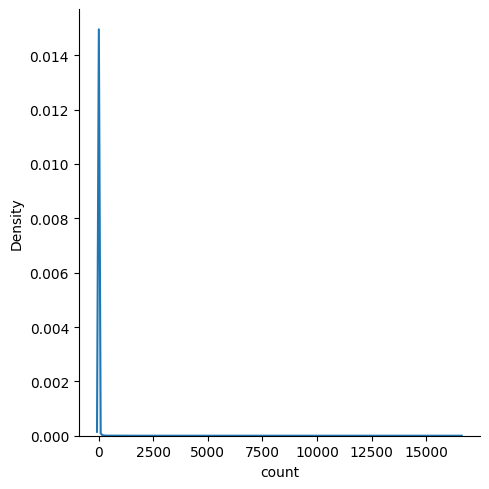

In [19]:
# plot sns distplot of mean_df['count']
import seaborn as sns

sns.displot(mean_df[mean_df["count"] > 1]["count"], kind="kde")

## No counting

In [37]:
bert_df[['value', 'tabular', 'phrase']][bert_df['tabular'] ==
                                        False].sort_values(by='value', ascending=False).head(50)

,value,tabular,phrase
240002,0.077176,False,fine
227618,0.069178,False,Vacci
234707,0.061394,False,Vacci
234757,0.059909,False,ears
236674,0.056772,False,no other concerns
224460,0.055987,False,No concerns
230887,0.054224,False,exam
220771,0.053272,False,vaccine
229519,0.052119,False,No v d c s.
231656,0.051040,False,vaccination as in


In [20]:
plt.boxplot(mean_df["count"], showfliers=False)

NameError: name 'plt' is not defined

In [ ]:
len(df["phrase"].unique()) / len(df)

0.1706103892206584

# Gropuing threshold 0.3

In [ ]:
configs = [
    "vet_50c_all_text",
    "vet_59c_ensemble_25",
    "vet_59c_ensemble_50",
    "vet_59c_ensemble_75",
    "vet_59c_stack",
    "vet_10c_all_text",
    "vet_19c_ensemble_25",
    "vet_19c_ensemble_50",
    "vet_19c_ensemble_75",
    "vet_19c_stack",
]

In [ ]:
df = pd.DataFrame(columns=["config", "phrase", "value"])

for config in configs:
    with open(
        f"/home/james/CodingProjects/ExplainPetBERT/{config}_all_tokens_30.pkl", "rb"
    ) as f:
        all_tokens = pickle.load(f)
    with open(
        f"/home/james/CodingProjects/ExplainPetBERT/{config}_all_values_30.pkl", "rb"
    ) as f:
        all_values = pickle.load(f)
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "config": [config for _ in range(len(all_tokens))],
                    "phrase": all_tokens,
                    "value": -all_values,  # negative because then it represents the vals for alive
                }
            ),
        ],
        ignore_index=True,
    )

The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.


In [ ]:
args = ConfigLoader(
    "vet_50c_all_text",
    "../configs/shap_configs.yaml",
    "../configs/dataset_default.yaml",
)

tab_cols = args.categorical_cols + args.numerical_cols

Updating with:
{'config': 'vet_50c_all_text', 'my_text_model': 'james-burton/vet_50c', 'ds_name': 'james-burton/vet_month_1c_all_text', 'text_model_base': 'SAVSNET/PetBERT_pretrained', 'model_type': 'all_text', 'ord_ds_name': 'james-burton/vet_month_1c_ordinal', 'text_cols': ['breed', 'region', 'record']}


{'categorical_cols': ['gender', 'neutered', 'species', 'insured'], 'numerical_cols_long': ['age_at_consult', 'Diseases of the ear or mastoid process', 'Mental, behavioural or neurodevelopmental disorders', 'Diseases of the blood or blood-forming organs', 'Diseases of the circulatory system', 'Dental', 'Developmental anomalies', 'Diseases of the digestive system', 'Endocrine, nutritional or metabolic diseases', 'Diseases of the Immune system', 'Certain infectious or parasitic diseases', 'Diseases of the skin', 'Diseases of the musculoskeletal system or connective tissue', 'Neoplasms', 'Diseases of the nervous system', 'Diseases of the visual system', 'Certain conditions originating i

In [ ]:
# check if each row in df contains tab_col + " ="
# if so, mark as tabular

df["tabular"] = [False for _ in range(len(df))]
for i, row in tqdm(df.iterrows()):
    for col in tab_cols:
        if col + " =" in row["phrase"]:
            df.loc[i, "tabular"] = True
            break

1066it [00:00, 10655.49it/s]

394995it [00:32, 12308.79it/s]


In [ ]:
df["count"] = [1 for _ in range(len(df))]

In [ ]:
df = df[df["tabular"] == False]

In [ ]:
for config in configs:
    with open(
        f"/home/james/CodingProjects/ExplainPetBERT/{config}_tab_tokens.pkl", "rb"
    ) as f:
        tab_tokens = pickle.load(f)
    with open(
        f"/home/james/CodingProjects/ExplainPetBERT/{config}_tab_values.pkl", "rb"
    ) as f:
        tab_values = pickle.load(f)
    df = pd.concat(
        [
            df,
            pd.DataFrame(
                {
                    "config": [config for _ in range(len(tab_tokens.reshape(-1)))],
                    "phrase": tab_tokens.reshape(-1),
                    "value": tab_values.reshape(-1),
                    "tabular": [True for _ in range(len(tab_tokens.reshape(-1)))],
                    "count": [1 for _ in range(len(tab_tokens.reshape(-1)))],
                }
            ),
        ],
        ignore_index=True,
    )

In [ ]:
bert_cfgs = [
    # "vet_10c_all_text",
    # "vet_19c_ensemble_25",
    "vet_19c_ensemble_50",
    # "vet_19c_ensemble_75",
    # "vet_19c_stack",
]

petbert_cfgs = [
    # "vet_50c_all_text",
    # "vet_59c_ensemble_25",
    "vet_59c_ensemble_50",
    # "vet_59c_ensemble_75",
    # "vet_59c_stack",
]

In [ ]:
bert_df = df[df["config"].isin(bert_cfgs)]
petbert_df = df[df["config"].isin(petbert_cfgs)]

In [ ]:
mean_df = df[["value", "phrase", "count", "tabular"]].groupby("phrase").mean()
count_df = df[["value", "phrase", "count", "tabular"]].groupby("phrase").count()
mean_df["count"] = count_df["count"]
mean_df["value"] = mean_df["value"]

In [ ]:
bert_mean_df = bert_df[["count", "tabular", "value", "phrase"]].groupby("phrase").mean()
bert_count_df = (
    bert_df[["count", "tabular", "value", "phrase"]].groupby("phrase").count()
)
bert_mean_df["count"] = bert_count_df["count"]
bert_mean_df["value"] = bert_mean_df["value"]

petbert_mean_df = (
    petbert_df[["count", "tabular", "value", "phrase"]].groupby("phrase").mean()
)
petbert_count_df = (
    petbert_df[["count", "tabular", "value", "phrase"]].groupby("phrase").count()
)
petbert_mean_df["count"] = petbert_count_df["count"]
petbert_mean_df["value"] = petbert_mean_df["value"]

bert_mean_df = bert_mean_df.reset_index()
petbert_mean_df = petbert_mean_df.reset_index()
bert_mean_df.sort_values(by="value", ascending=False, inplace=True)
petbert_mean_df.sort_values(by="value", ascending=False, inplace=True)

bert_mean_df_down = bert_mean_df.sort_values(by="value", ascending=True)
petbert_mean_df_down = petbert_mean_df.sort_values(by="value", ascending=True)

bert_mean_df = pd.concat(
    [bert_mean_df.reset_index(drop=True), bert_mean_df_down.reset_index(drop=True)],
    axis=1,
)
petbert_mean_df = pd.concat(
    [
        petbert_mean_df.reset_index(drop=True),
        petbert_mean_df_down.reset_index(drop=True),
    ],
    axis=1,
)

In [ ]:
petbert_mean_df

,phrase,count,tabular,value,phrase,count,tabular,value
0,(Text ft) record = C1G0,1,0.0,0.165788,cannot guarantee if would spread,1,0.0,-0.134808
1,Vaccinated,1,0.0,0.141237,does not think vivitonin made much difference ...,1,0.0,-0.127114
2,endectrid,1,0.0,0.132106,/preds,1,0.0,-0.121591
3,bosoter,1,0.0,0.119060,owner aware slow decline inevitable.,1,0.0,-0.107920
4,vac,1,0.0,0.107547,age_at_consult = 19.86,1,1.0,-0.107650
...,...,...,...,...,...,...,...,...
19706,age_at_consult = 19.86,1,1.0,-0.107650,vac,1,0.0,0.107547
19707,owner aware slow decline inevitable.,1,0.0,-0.107920,bosoter,1,0.0,0.119060
19708,/preds,1,0.0,-0.121591,endectrid,1,0.0,0.132106
19709,does not think vivitonin made much difference ...,1,0.0,-0.127114,Vaccinated,1,0.0,0.141237


In [ ]:
# join bert_mean_df_down to bert_mean_df with same cols but suffix 2, joining side by side not on index or phrase
bert_mean_df

,phrase,count,tabular,value,phrase,count,tabular,value
0,age_at_consult = 10.12,1,1.0,0.099025,AND WEIGHT LOST,1,0.0,-0.108401
1,age_at_consult = 10.13,1,1.0,0.093325,age_at_consult = 19.86,1,1.0,-0.107650
2,age_at_consult = 10.59,1,1.0,0.092303,age_at_consult = 19.72,1,1.0,-0.107571
3,age_at_consult = 10.81,1,1.0,0.090481,losing a lot of weight,1,0.0,-0.105474
4,age_at_consult = 10.3,1,1.0,0.090159,appetite is slightly reduced,1,0.0,-0.105162
...,...,...,...,...,...,...,...,...
14254,appetite is slightly reduced,1,0.0,-0.105162,age_at_consult = 10.3,1,1.0,0.090159
14255,losing a lot of weight,1,0.0,-0.105474,age_at_consult = 10.81,1,1.0,0.090481
14256,age_at_consult = 19.72,1,1.0,-0.107571,age_at_consult = 10.59,1,1.0,0.092303
14257,age_at_consult = 19.86,1,1.0,-0.107650,age_at_consult = 10.13,1,1.0,0.093325


In [ ]:
bert_mean_df

,phrase,count,tabular,value
6770,age_at_consult = 10.12,1,1.0,0.099025
6771,age_at_consult = 10.13,1,1.0,0.093325
6804,age_at_consult = 10.59,1,1.0,0.092303
6822,age_at_consult = 10.81,1,1.0,0.090481
6780,age_at_consult = 10.3,1,1.0,0.090159
...,...,...,...,...
7769,appetite is slightly reduced,1,0.0,-0.105162
10678,losing a lot of weight,1,0.0,-0.105474
7345,age_at_consult = 19.72,1,1.0,-0.107571
7347,age_at_consult = 19.86,1,1.0,-0.107650


In [ ]:
bert_mean_df_down.reset_index(drop=True)

,phrase,count,tabular,value
0,AND WEIGHT LOST,1,0.0,-0.108401
1,age_at_consult = 19.86,1,1.0,-0.107650
2,age_at_consult = 19.72,1,1.0,-0.107571
3,losing a lot of weight,1,0.0,-0.105474
4,appetite is slightly reduced,1,0.0,-0.105162
...,...,...,...,...
14254,age_at_consult = 10.3,1,1.0,0.090159
14255,age_at_consult = 10.81,1,1.0,0.090481
14256,age_at_consult = 10.59,1,1.0,0.092303
14257,age_at_consult = 10.13,1,1.0,0.093325


In [ ]:
# Save bert_mean_df and petbert_mean_df to csv
bert_mean_df.to_csv("bert_mean_df_stack.csv")
petbert_mean_df.to_csv("petbert_mean_df_stack.csv")